#A - Overview and Objective

**Objective:**

The objective of this analysis is to develop a convolutional neural network capabale of classifying images with cracked concrete from images with no surface defects. Through transfer learning, MobileNetV2 and Inception V3 CNNs will be utilized for classifying the concrete images and have their performance compared to the developed CNN. The models' classification decisions will be explained using class activation maps.

**Dataset overview:**

The dataset contains concrete images having cracks. The data is collected from various METU Campus Buildings.
The dataset is divided into two as negative and positive crack images for image classification. 
Each class has 20000images with a total of 40000 images with 227 x 227 pixels with RGB channels. 
The dataset is generated from 458 high-resolution images (4032x3024 pixel) with the method proposed by Zhang et al (2016). 
High-resolution images have variance in terms of surface finish and illumination conditions. 
No data augmentation in terms of random rotation or flipping is applied. 

data source link: https://www.kaggle.com/datasets/arnavr10880/concrete-crack-images-for-classification

**Citations:**
*   2018 – Özgenel, Ç.F., Gönenç Sorguç, A. “Performance Comparison of Pretrained Convolutional Neural Networks on Crack Detection in Buildings”, ISARC 2018, Berlin.
*   Lei Zhang , Fan Yang , Yimin Daniel Zhang, and Y. J. Z., Zhang, L., Yang, F., Zhang, Y. D., & Zhu, Y. J. (2016). Road Crack Detection Using Deep Convolutional Neural Network. In 2016 IEEE International Conference on Image Processing (ICIP). http://doi.org/10.1109/ICIP.2016.7533052

#B - Setup

##1.0 Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import PIL
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.regularizers import l2

from PIL import Image
from numpy import asarray
from pathlib import Path

import keras
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from sklearn.externals.joblib import parallel_backend


#from tensorflow import keras
from tensorflow.keras import Model,layers
#from IPython.display import Image, display
import matplotlib.cm as cm

In [ ]:
import IPython
import IPython.display

##2.0 Read Dataset

Connect to Google Drive to get Kaggle credentials and download data from Kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! ! cp /content/drive/MyDrive/Datasets/Concrete_Crack_Detection/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download arunrk7/surface-crack-detection

 91% 212M/233M [00:01<00:00, 164MB/s]
100% 233M/233M [00:01<00:00, 143MB/s]


In [ ]:
! unzip surface-crack-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: Positive/15001_1.jpg    
  inflating: Positive/15002_1.jpg    
  inflating: Positive/15003_1.jpg    
  inflating: Positive/15004_1.jpg    
  inflating: Positive/15005_1.jpg    
  inflating: Positive/15006_1.jpg    
  inflating: Positive/15007_1.jpg    
  inflating: Positive/15008_1.jpg    
  inflating: Positive/15009_1.jpg    
  inflating: Positive/15010_1.jpg    
  inflating: Positive/15011_1.jpg    
  inflating: Positive/15012_1.jpg    
  inflating: Positive/15013_1.jpg    
  inflating: Positive/15014_1.jpg    
  inflating: Positive/15015_1.jpg    
  inflating: Positive/15016_1.jpg    
  inflating: Positive/15017_1.jpg    
  inflating: Positive/15018_1.jpg    
  inflating: Positive/15019_1.jpg    
  inflating: Positive/15020_1.jpg    
  inflating: Positive/15021_1.jpg    
  inflating: Positive/15022_1.jpg    
  inflating: Positive/15023_1.jpg    
  inflating: Positive/15024_1.jpg    
  inflating: Positive/15025_1.jpg    

###2.1 Open Image of Each Class

Opening a JPEG File and getting an idea of shape

In [ ]:
img = Image.open('Positive/19425.jpg') #open image

numpydata = asarray(img) #put image into an array
  
# <class 'numpy.ndarray'>
print(type(numpydata))
  
#  shape
print(numpydata.shape)

<class 'numpy.ndarray'>
(227, 227, 3)


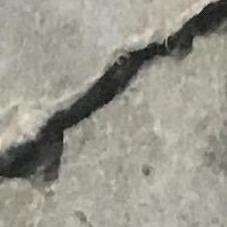

In [ ]:
pil_im = Image.open('Positive/19425.jpg')
display(pil_im)

Example of image classified as 'Positive' with crack. 

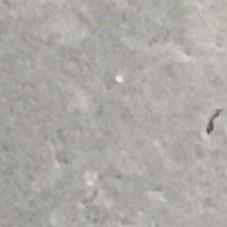

In [ ]:
pil_im = Image.open('Negative/00001.jpg')
display(pil_im)


Example image with no crack, classified as 'Negative'

#C - Pre-processing

##1.0 Create dataframe with image filepath and label

In [ ]:
#Define image directory path
positive_dir=Path("../content/Positive")
negative_dir=Path("../content/Negative")

In [ ]:
#Function to create dataframe with image filepath and labels
def DataFrame_create(image_dir,label):
    filepaths=pd.Series(list(image_dir.glob(r"*.jpg")),name="Filepath").astype(str)
    labels=pd.Series(label,name="label",index=filepaths.index)
    dataframe=pd.concat([filepaths,labels],axis=1)
    
    return dataframe

In [ ]:
#create positive and negative image dataframes
positive_df=DataFrame_create(positive_dir,label='positive')
negative_df=DataFrame_create(negative_dir,label='negative')

In [ ]:
#Combine positive and negative dataframe into single dataframe. Frac = 5% of data is put into df (5% of 40,000 images)
df=pd.concat([positive_df,negative_df],axis=0).sample(frac=.05, random_state=1).reset_index(drop=True)
df.head()

,Filepath,label
0,../content/Positive/06692.jpg,positive
1,../content/Positive/04918.jpg,positive
2,../content/Positive/15978_1.jpg,positive
3,../content/Negative/04106.jpg,negative
4,../content/Positive/03594.jpg,positive


##2.0 Check for Class Imbalance

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Number positive :  1022
Number negative :  978


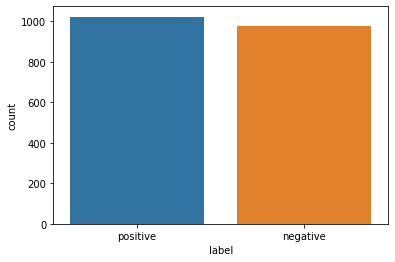

In [ ]:
ax = sns.countplot(df.label,label="Count") ;
positive, negative = df.label.value_counts();
print('Number positive : ', positive);
print('Number negative : ', negative);

The classes are well balanced

##3.0 Train/Validation/Test Split

In [ ]:
#Train/Test Split 
train_df,test_df=train_test_split(df,train_size=0.8,shuffle=True)

In [ ]:
#Number of images in train dataframe
train_df['label'].value_counts()

positive    815
negative    785
Name: label, dtype: int64

In [ ]:
#Number of images in test dataframe
test_df['label'].value_counts()

positive    207
negative    193
Name: label, dtype: int64

In [ ]:
test_df.head(10)

,Filepath,label
1155,../content/Negative/08975.jpg,negative
314,../content/Negative/09250.jpg,negative
1665,../content/Positive/01223.jpg,positive
467,../content/Positive/07183.jpg,positive
15,../content/Negative/13099.jpg,negative
1842,../content/Positive/15435_1.jpg,positive
1017,../content/Positive/11034_1.jpg,positive
1678,../content/Negative/03234.jpg,negative
954,../content/Negative/10738.jpg,negative
488,../content/Positive/11443_1.jpg,positive


In [ ]:
#Generate batches of tensor image data with real-time data augmentation.

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, #pixel values down into a range of between 0 and 1
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
#Takes the dataframe and the path to a directory + generates batches. The generated batches contain augmented/normalized data.

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='binary',
    batch_size=128,
    shuffle=True,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='binary',
    batch_size=128,
    shuffle=True,
    subset='validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='binary',
    batch_size=128,
    shuffle=False,
)

Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


#D - Modeling

##1.0 Baseline CNN Model

The Baseline CNN model was loosely based the popular VGG (Visual Geometry Group) model architecture. VGG is a very deep network (VGG16 consists of 16 convoluional layers) and uses 3x3 kernal sizes. All VGG hidden layers use an RELU activation function. This model consists of 4 convolutional layers, 2 maxpooling layers, 1 flattening layer, and 2 dense layers. The filter size also doubles through each convolutional layer stack, which is a key principle of VGG architecture.

https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

###1.1 Create Model

In [ ]:
#Baseline

baseline_model = Sequential()
baseline_model.add(Conv2D(16,1,padding="same", activation="relu", strides=2, input_shape = (128,128,3)))
baseline_model.add(Conv2D(16,1, padding="same", strides=2, activation="relu"))
baseline_model.add(MaxPool2D())

baseline_model.add(Conv2D(32, 3, padding="same", strides=2, activation="relu"))
baseline_model.add(Conv2D(32, 3, padding="same", strides=2, activation="relu"))
baseline_model.add(MaxPool2D())

baseline_model.add(Flatten())
baseline_model.add(Dense(64,activation="relu"))
baseline_model.add(Dropout(0.5))

baseline_model.add(Dense(2, activation="softmax"))

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        64        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                    

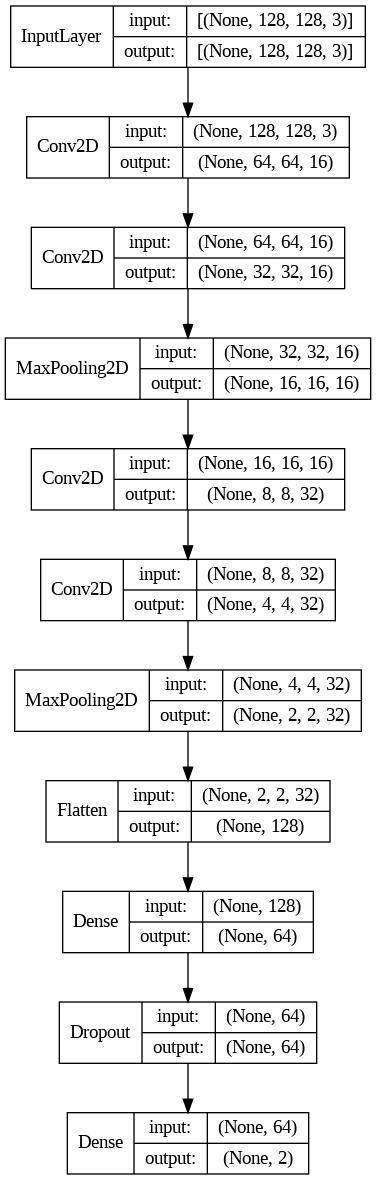

In [ ]:
tf.keras.utils.plot_model(baseline_model, to_file='baseline_model.png', show_shapes=True, show_layer_names=False)

###1.2 Baseline Model Results

In [ ]:
baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'] )
baseline_history = baseline_model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/20
10/10 [==============================] - 8s 655ms/step - loss: 0.6955 - accuracy: 0.4922 - val_loss: 0.6925 - val_accuracy: 0.4875
Epoch 2/20
10/10 [==============================] - 7s 677ms/step - loss: 0.6906 - accuracy: 0.5375 - val_loss: 0.6898 - val_accuracy: 0.4875
Epoch 3/20
10/10 [==============================] - 6s 635ms/step - loss: 0.6870 - accuracy: 0.5820 - val_loss: 0.6870 - val_accuracy: 0.4875
Epoch 4/20
10/10 [==============================] - 4s 367ms/step - loss: 0.6807 - accuracy: 0.5664 - val_loss: 0.6724 - val_accuracy: 0.8438
Epoch 5/20
10/10 [==============================] - 3s 340ms/step - loss: 0.6592 - accuracy: 0.6922 - val_loss: 0.6338 - val_accuracy: 0.8156
Epoch 6/20
10/10 [==============================] - 3s 334ms/step - loss: 0.6008 - accuracy: 0.7430 - val_loss: 0.5371 - val_accuracy: 0.8281
Epoch 7/20
10/10 [==============================] - 3s 339ms/step - loss: 0.4836 - accuracy: 0.8422 - val_loss: 0.4035 - val_accuracy: 0.8750
Epoch 

In [ ]:
import matplotlib.pyplot as plt
def plot_metrics(baseline_history):
  metrics =  ['loss','accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.tight_layout()
    plt.plot(baseline_history.epoch,  baseline_history.history[metric], color=colors[0], label='Train')
    plt.plot(baseline_history.epoch, baseline_history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

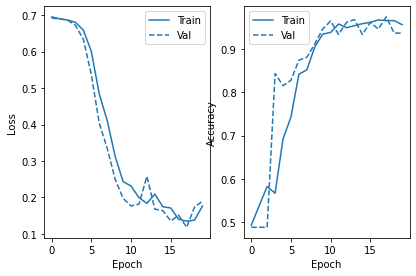

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(baseline_history)

1/1 [==============================] - 0s 138ms/step


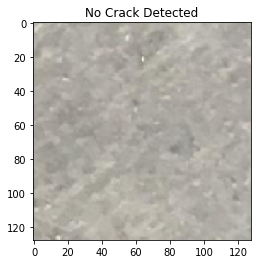

In [ ]:
#Test model on an image
image = tf.keras.preprocessing.image.load_img("../content/Negative/08693.jpg", target_size=(128,128))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = baseline_model.predict(input_arr)

plt.figure()
plt.imshow(image)

if(predictions[0][1]>=0.5):
    plt.title("Crack Detected")
else:
    plt.title("No Crack Detected")

1/1 [==============================] - 0s 19ms/step


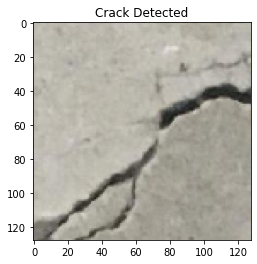

In [ ]:
#Test model on an image
image = tf.keras.preprocessing.image.load_img("../content/Positive/04092.jpg", target_size=(128,128))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = baseline_model.predict(input_arr)

plt.figure()
plt.imshow(image)

if(predictions[0][1]>=0.5):
    plt.title("Crack Detected")
else:
    plt.title("No Crack Detected")

In [ ]:
baseline_results = baseline_model.evaluate(test_data, verbose = 0)
baseline_loss = baseline_results[0]
baseline_acc = baseline_results[1]

print('Baseline Test loss:', baseline_loss) 
print('Baseline Test accuracy:', baseline_acc)

Baseline Test loss: 0.17325277626514435
Baseline Test accuracy: 0.9474999904632568


##2.0 Hyperparameter Tuning


###2.1 Tune Baseline Model

In [ ]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64]
hiddenLayerTwo = [16, 32, 64]
hiddenLayerThree = [16, 32, 64]
hiddenLayerFour = [16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
hiddenDense = [64, 128, 256]
kernel_size = [1,3]
strides = [1,2,3]
dropout_rate = [0.3, 0.4, 0.5]
#batchSize = [32,64,128]

# create a dictionary from the hyperparameter grid
param_grid = dict(
  hiddenLayerOne=hiddenLayerOne,
  hiddenLayerTwo=hiddenLayerTwo,
  hiddenLayerThree=hiddenLayerThree,
  hiddenLayerFour=hiddenLayerFour,
  kernel_size=kernel_size,
  hiddenDense=hiddenDense,
  learnRate=learnRate,
  strides=strides,
  #batch_size=batchSize,
  dropout_rate = dropout_rate,
)

In [ ]:
# Function to create model
def create_model(hiddenLayerOne=16, hiddenLayerTwo=16, hiddenLayerThree=32, hiddenLayerFour=32, hiddenDense=64, learnRate=0.01, strides=2, dropout_rate=.3, kernel_size=1):
	# create model
  model = Sequential()
  model.add(Conv2D(hiddenLayerOne, kernel_size=kernel_size, padding="same", activation='relu', strides=strides, kernel_regularizer=keras.regularizers.l2(), input_shape = (128,128,3)))
  model.add(Conv2D(hiddenLayerTwo, kernel_size=kernel_size, padding="same", strides=strides, kernel_regularizer=keras.regularizers.l2(), activation="relu"))
  model.add(MaxPool2D())

  model.add(Conv2D(hiddenLayerThree, kernel_size=kernel_size, padding="same", strides=strides, kernel_regularizer=keras.regularizers.l2(), activation="relu"))
  model.add(Conv2D(hiddenLayerFour, kernel_size=kernel_size, padding="same", strides=strides, kernel_regularizer=keras.regularizers.l2(), activation="relu"))
  model.add(MaxPool2D())
  
  model.add(Flatten())
  model.add(Dense(hiddenDense, activation="relu"))
  model.add(layers.Dropout(dropout_rate))
  model.add(Dense(2, activation='softmax'))
 
	# Compile model
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learnRate), metrics=['accuracy'])
  return model

In [ ]:
# Random Grid Search
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

clf = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, scoring='accuracy')

with parallel_backend('threading'):
  tuned_baseline_model = clf.fit(train_data[0][0], train_data[0][1], epochs=5, validation_data=val_data, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)])

# summarize results
print(tuned_baseline_model.best_params_)

<ipython-input-34-3ef578c0fe7b>:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=1)


Epoch 1/5
Epoch 1/5
3/3 [==============================] - 4s 1s/step - loss: 1.5321 - accuracy: 0.5647 - val_loss: 1.5201 - val_accuracy: 0.4875
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 1.5119 - accuracy: 0.5059 - val_loss: 1.4947 - val_accuracy: 0.4875
Epoch 2/5
3/3 [==============================] - 2s 714ms/step - loss: 1.5094 - accuracy: 0.5059 - val_loss: 1.4992 - val_accuracy: 0.4875
Epoch 3/5
3/3 [==============================] - 2s 746ms/step - loss: 1.4828 - accuracy: 0.6000 - val_loss: 1.4724 - val_accuracy: 0.4875
Epoch 3/5
3/3 [==============================] - 2s 705ms/step - loss: 1.4886 - accuracy: 0.4941 - val_loss: 1.4790 - val_accuracy: 0.4875
Epoch 4/5
3/3 [==============================] - 2s 707ms/step - loss: 1.4668 - accuracy: 0.4706 - val_loss: 1.4502 - val_accuracy: 0.4875
Epoch 4/5
3/3 [==============================] - 2s 731ms/step - loss: 1.4644 - accuracy: 0.5294 - val_loss: 1.4568 - val_accuracy: 0.4875
Epoch 5/5
3/3 [========

2/2 [==============================] - 3s 269ms/step
Epoch 1/5
3/3 [==============================] - 18s 7s/step - loss: 2.2421 - accuracy: 0.5233 - val_loss: 2.2261 - val_accuracy: 0.5125
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 2.2406 - accuracy: 0.5465

3/3 [==============================] - 18s 7s/step - loss: 2.2406 - accuracy: 0.5465 - val_loss: 2.2088 - val_accuracy: 0.5125
Epoch 3/5
Epoch 1/5
3/3 [==============================] - 23s 9s/step - loss: 2.5395 - accuracy: 0.5059 - val_loss: 2.9253 - val_accuracy: 0.4875
Epoch 2/5
3/3 [==============================] - 36s 15s/step - loss: 2.2108 - accuracy: 0.5698 - val_loss: 2.1935 - val_accuracy: 0.5000
Epoch 4/5
3/3 [==============================] - 13s 5s/step - loss: 2.4586 - accuracy: 0.5529 - val_loss: 1.9779 - val_accuracy: 0.4875
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.8305 - accuracy: 0.5059 - val_loss: 1.6785 - val_accuracy: 0.5125
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.6917 - accuracy: 0.4706 - val_loss: 1.6643 - val_accuracy: 0.5125
Epoch 5/5
2/2 [==============================] - 1s 258ms/step
Epoch 1/5
3/3 [==============================] - 26s 10s/step - loss: 2.1929 - accuracy: 0.5349 - val_loss: 2.1808 -

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_learn.py", line 155, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_

Epoch 1/5
4/4 [==============================] - 8s 2s/step - loss: 2.3490 - accuracy: 0.4688 - val_loss: 1.2994 - val_accuracy: 0.4875
Epoch 2/5
4/4 [==============================] - 8s 2s/step - loss: 1.4687 - accuracy: 0.5000 - val_loss: 1.2208 - val_accuracy: 0.4875
Epoch 3/5
4/4 [==============================] - 7s 2s/step - loss: 1.1951 - accuracy: 0.5703 - val_loss: 1.1833 - val_accuracy: 0.5125
Epoch 4/5
4/4 [==============================] - 7s 2s/step - loss: 1.1727 - accuracy: 0.5312 - val_loss: 1.1518 - val_accuracy: 0.4875
Epoch 5/5
4/4 [==============================] - 7s 2s/step - loss: 1.1407 - accuracy: 0.5312 - val_loss: 1.1132 - val_accuracy: 0.8062
{'strides': 1, 'learnRate': 0.001, 'kernel_size': 3, 'hiddenLayerTwo': 16, 'hiddenLayerThree': 16, 'hiddenLayerOne': 16, 'hiddenLayerFour': 32, 'hiddenDense': 256, 'dropout_rate': 0.5}


###2.2 Best Hyperparameters

In [ ]:
print(clf.best_params_)

{'strides': 1, 'learnRate': 0.001, 'kernel_size': 3, 'hiddenLayerTwo': 16, 'hiddenLayerThree': 16, 'hiddenLayerOne': 16, 'hiddenLayerFour': 32, 'hiddenDense': 256, 'dropout_rate': 0.5}


###2.3 Tuned Model Results

In [ ]:
# Create model with best parameters

model_tuned = Sequential()
model_tuned.add(Conv2D(16,3,padding="same", kernel_regularizer=keras.regularizers.l2(), activation="relu", strides=2, input_shape = (128,128,3)))
model_tuned.add(Conv2D(16,3, padding="same", kernel_regularizer=keras.regularizers.l2(), strides=1, activation="relu"))
model_tuned.add(MaxPool2D())

model_tuned.add(Conv2D(16, 3, padding="same", kernel_regularizer=keras.regularizers.l2(), strides=1, activation="relu"))
model_tuned.add(Conv2D(32, 3, padding="same", kernel_regularizer=keras.regularizers.l2(), strides=1, activation="relu"))
model_tuned.add(MaxPool2D())

model_tuned.add(Flatten())
model_tuned.add(Dense(256,activation="relu"))
model_tuned.add(Dropout(0.5))
model_tuned.add(Dense(2, activation="softmax"))

model_tuned.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                  

In [ ]:
model_tuned.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=.001), metrics=['accuracy'])
tuned_history = model_tuned.fit(train_data, validation_data=val_data, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/20
10/10 [==============================] - 14s 1s/step - loss: 1.2478 - accuracy: 0.5219 - val_loss: 1.1557 - val_accuracy: 0.4875
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 1.0786 - accuracy: 0.6414 - val_loss: 0.9647 - val_accuracy: 0.8531
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 0.8004 - accuracy: 0.9102 - val_loss: 0.6184 - val_accuracy: 0.9469
Epoch 4/20
10/10 [==============================] - 13s 1s/step - loss: 0.5332 - accuracy: 0.9594 - val_loss: 0.4702 - val_accuracy: 0.9594
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 0.4170 - accuracy: 0.9750 - val_loss: 0.4112 - val_accuracy: 0.9594
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 0.3606 - accuracy: 0.9820 - val_loss: 0.3318 - val_accuracy: 0.9688
Epoch 7/20
10/10 [==============================] - 14s 1s/step - loss: 0.3441 - accuracy: 0.9797 - val_loss: 0.4571 - val_accuracy: 0.9156
Epoch 8/20
10/10 [==

In [ ]:
import matplotlib.pyplot as plt
def plot_metrics(tuned_history):
  metrics =  ['loss','accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.tight_layout()
    plt.plot(tuned_history.epoch,  tuned_history.history[metric], color=colors[0], label='Train')
    plt.plot(tuned_history.epoch, tuned_history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

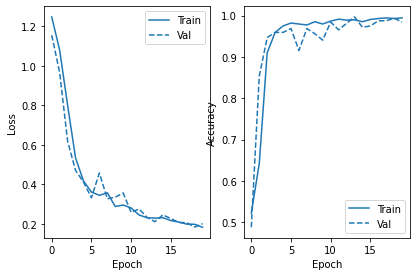

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(tuned_history)

1/1 [==============================] - 0s 101ms/step


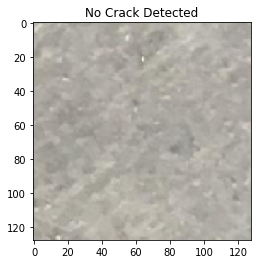

In [ ]:
#Test model on an image
image = tf.keras.preprocessing.image.load_img("../content/Negative/08693.jpg", target_size=(128,128))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = model_tuned.predict(input_arr)

plt.figure()
plt.imshow(image)

if(predictions[0][1]>=0.5):
    plt.title("Crack Detected")
else:
    plt.title("No Crack Detected")

1/1 [==============================] - 0s 22ms/step


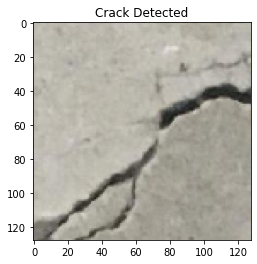

In [ ]:
#Test model on an image
image = tf.keras.preprocessing.image.load_img("../content/Positive/04092.jpg", target_size=(128,128))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = model_tuned.predict(input_arr)

plt.figure()
plt.imshow(image)

if(predictions[0][1]>=0.5):
    plt.title("Crack Detected")
else:
    plt.title("No Crack Detected")

In [ ]:
tuned_results = model_tuned.evaluate(test_data, verbose = 0)
tuned_loss = tuned_results[0]
tuned_acc = tuned_results[1]

print('Tuned Test loss:', tuned_loss) 
print('Tuned Test accuracy:', tuned_acc)

Tuned Test loss: 0.19944778084754944
Tuned Test accuracy: 0.9850000143051147


##3.0 - Transfer Learning

###3.1 MobileNetV2

A base model created by Google, originally trained on an image set with 1000 classes

In [ ]:
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
     layer.trainable = False

pre_trained_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [ ]:
last_layer = pre_trained_model.get_layer('out_relu') 
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.5)(x)                  
# Add a final softmax layer for classification
x = layers.Dense  (2, activation='softmax')(x) 

In [ ]:
from tensorflow.keras import Model,layers

model = Model(pre_trained_model.input, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/20
10/10 [==============================] - 22s 2s/step - loss: 3.9914 - accuracy: 0.8406 - val_loss: 0.3880 - val_accuracy: 0.9781
Epoch 2/20
10/10 [==============================] - 18s 2s/step - loss: 0.1573 - accuracy: 0.9914 - val_loss: 0.0748 - val_accuracy: 0.9906
Epoch 3/20
10/10 [==============================] - 17s 2s/step - loss: 0.1312 - accuracy: 0.9914 - val_loss: 0.1182 - val_accuracy: 0.9937
Epoch 4/20
10/10 [==============================] - 17s 2s/step - loss: 0.1238 - accuracy: 0.9953 - val_loss: 0.1798 - val_accuracy: 0.9937
Epoch 5/20
10/10 [==============================] - 17s 2s/step - loss: 0.0607 - accuracy: 0.9969 - val_loss: 0.1147 - val_accuracy: 0.9937


In [ ]:
import matplotlib.pyplot as plt
def plot_metrics(history):
  metrics =  ['loss','accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.tight_layout()
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

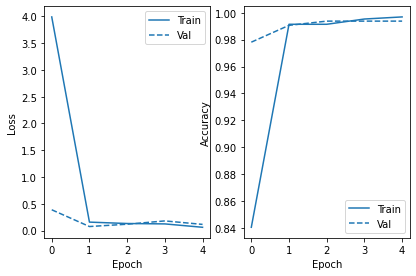

In [ ]:
# Plot the training/validation history of our Keras model
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(history)

In [ ]:
mobilev2_results = model.evaluate(test_data, verbose = 0)
mobilev2_loss = mobilev2_results[0]
mobilev2_acc = mobilev2_results[1]

print('MobileV2 Test loss:', mobilev2_loss) 
print('MobileV2 Test accuracy:', mobilev2_acc)

MobileV2 Test loss: 7.659079415134329e-08
MobileV2 Test accuracy: 1.0


###3.2 InceptionV3

In [ ]:
pre_trained_model = tf.keras.applications.InceptionV3(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
     layer.trainable = False

pre_trained_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d_12[0][0]']              
 alization)                                                                                       
                      

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7') 
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.5)(x)                  
# Add a final softmax layer for classification
x = layers.Dense  (2, activation='softmax')(x) 

In [ ]:
from tensorflow.keras import Model,layers

model = Model(pre_trained_model.input, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d_12[0][0]']              
 alization)                                                                                       
                                                                                            

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/20
10/10 [==============================] - 49s 4s/step - loss: 0.2811 - accuracy: 0.9203 - val_loss: 0.2836 - val_accuracy: 0.9688
Epoch 2/20
10/10 [==============================] - 42s 4s/step - loss: 0.0662 - accuracy: 0.9922 - val_loss: 0.0676 - val_accuracy: 0.9937
Epoch 3/20
10/10 [==============================] - 42s 4s/step - loss: 0.0424 - accuracy: 0.9930 - val_loss: 0.0230 - val_accuracy: 0.9969
Epoch 4/20
10/10 [==============================] - 41s 4s/step - loss: 0.0313 - accuracy: 0.9961 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 41s 4s/step - loss: 0.0261 - accuracy: 0.9984 - val_loss: 0.0221 - val_accuracy: 0.9937
Epoch 6/20
10/10 [==============================] - 41s 4s/step - loss: 0.0119 - accuracy: 0.9992 - val_loss: 0.0187 - val_accuracy: 0.9937
Epoch 7/20
10/10 [==============================] - 41s 4s/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 0.0327 - val_accuracy: 0.9937


In [ ]:
import matplotlib.pyplot as plt
def plot_metrics(history):
  metrics =  ['loss','accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.tight_layout()
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

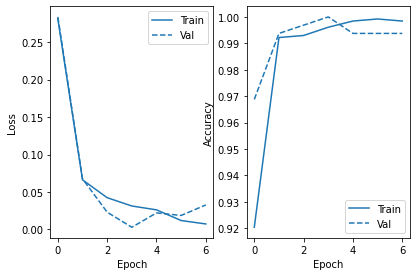

In [ ]:
# Plot the training/validation history of our Keras model
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(history)

In [ ]:
inceptionv3_results = model.evaluate(test_data, verbose = 0)
inceptionv3_loss = inceptionv3_results[0]
inceptionv3_acc = inceptionv3_results[1]

print('InceptionV3 Test loss:', inceptionv3_loss) 
print('InceptionV3 Test accuracy:', inceptionv3_acc)

InceptionV3 Test loss: 0.016351589933037758
InceptionV3 Test accuracy: 0.9950000047683716


#F - Model Comparison

In [ ]:
#store metrics in respective lists
models = ['baseline','tuned baseline','mobilenetv2', 'inceptionv3']
accuracies = [baseline_acc, tuned_acc, mobilev2_acc, inceptionv3_acc]
loss = [baseline_loss, tuned_loss, mobilev2_loss, inceptionv3_loss]

#create dataframe with metrics for comparison
df__final_evaluate = pd.DataFrame()
df__final_evaluate['Model'] = models
df__final_evaluate['Loss'] = loss
df__final_evaluate['Accuracy'] = accuracies

df_evaluate = df__final_evaluate.sort_values(by=['Accuracy'], ascending=False)
df_evaluate

,Model,Loss,Accuracy
2,mobilenetv2,7.659079e-08,1.0000
3,inceptionv3,1.635159e-02,0.9950
1,tuned baseline,1.994478e-01,0.9850
0,baseline,1.732528e-01,0.9475


Observing the model results, all models perform extremely well at classifying the two classes of image. It was possible to create a baseline model that performs comparably to established classification architectures

#G - Explainable AI with Class Activation Heatmap

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model,layers
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
model_builder = keras.applications.mobilenet_v2.MobileNetV2
img_size = (224, 224)
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
decode_predictions = keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "out_relu"

#img_path = '../content/Positive/19425.jpg'	
#img_path = '../content/Negative/15452.jpg'

img_path_neg = '../content/Negative/08975.jpg'
img_path_pos = '../content/Positive/01223.jpg'

#display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # Add dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # create model that maps the input image to the activations
    # of the last conv layer and output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # gradient of the output neuron with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # multiply each channel in the feature map array by how important this channel is with regard to the top predicted class, then sum the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 933ms/step
[-0.00266686 -0.00340406]
No Crack Detected


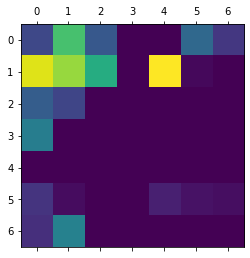

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path_neg, size=img_size))

# Make model
model = model_builder(weights="imagenet")

last_layer = model.get_layer('predictions') 
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.5)(x)                  
# Add a final softmax layer for classification
x = layers.Dense  (2, activation='softmax')(x) 
model = Model(model.input, x)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds[0])
#print("Predicted:", decode_predictions(preds, top=1)[0])
if(preds[0][1]>preds[0][0]):
    print("Crack Detected")#plt.title("Crack Detected")
else:
    print("No Crack Detected")#plt.title("No Crack Detected")

# Generate class activation heatmap
heatmap_neg = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap_neg)
plt.show()

1/1 [==============================] - 1s 920ms/step
[-0.00604577  0.00768467]
Crack Detected


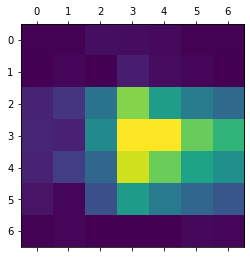

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path_pos, size=img_size))

# Make model
model = model_builder(weights="imagenet")

last_layer = model.get_layer('predictions') 
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.5)(x)                  
# Add a final softmax layer for classification
x = layers.Dense  (2, activation='softmax')(x) 
model = Model(model.input, x)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds[0])
#print("Predicted:", decode_predictions(preds, top=1)[0])
if(preds[0][1]>preds[0][0]):
    print("Crack Detected")#plt.title("Crack Detected")
else:
    print("No Crack Detected")#plt.title("No Crack Detected")

# Generate class activation heatmap
heatmap_pos = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap_pos)
plt.show()

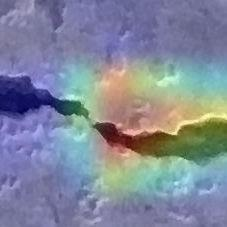

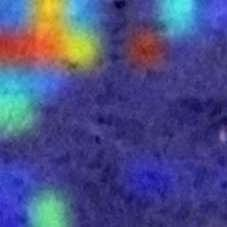

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path_pos, heatmap_pos)
save_and_display_gradcam(img_path_neg, heatmap_neg)

In [ ]:
%%shell
jupyter nbconvert --to html /content/Surface_Crack_Detection_v1.ipynb

[NbConvertApp] Converting notebook /content/Surface_Crack_Detection_v1.ipynb to html
[NbConvertApp] Writing 1483636 bytes to /content/Surface_Crack_Detection_v1.html
